In [35]:
import numpy as np
import os.path
from scipy import ndimage
import itertools
import matplotlib as mpl
import math
import matplotlib.pyplot as plt
from mapping import creategrid as grd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import pandas as pd
from eod import msg as msg
pylab.rcParams['figure.figsize'] = (16., 16.)
%matplotlib inline

###### Choose a TRMM swath file: 12.06.2011, 21:30 (excludes all cases with "no TRMM overpass")

In [3]:
# read only trmm files that I need and give out proper lons lats etc
files = "/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA/2011/06/2A25.20110612.77322.7.gra"
 # /2011/06/2A25.20110612.77322.7.gra"  good to show
trr = np.fromfile(files,dtype=np.int16) 
x = 49
nb = trr.size
single = int(nb/4) # variables lon lat rainrate flag

lons = trr[0:single]
lats = trr[single:2*single]
rainrs = trr[2*single:3*single]
flags = trr[3*single:4*single]

In [4]:
flags=np.array([163])
bla=flags.astype(int)
npfalse=[]

for b, i in zip(np.nditer(bla), range(bla.size)): 
    print(b)
    print(i)
    bb='{0:016b}'.format(int(b))   
    print(bb)
    npfalse.append(int(bb[-6]))

163
0
0000000010100011


In [5]:
y = int(lons.size/x)
lons = np.resize(lons, (y,x))
lats = np.resize(lats, (y,x))
rainrs = np.resize(rainrs, (y,x))
flags = np.resize(flags, (y,x))
lon=lons/100.
lat=lats/100.
rainr=rainrs/10.
lonmin, lonmax=np.amin(lon),np.amax(lon)
latmin, latmax=np.amin(lat),np.amax(lat)
lonx=lon[0,:]
laty=lat[:,0]
rainrs.shape

(1159, 49)

###### Remark: TRMM times are assigned to closest full or half hour! Can be a max. difference of 15 minutes! Filter might be needed. 

Get the mask for convective pixels

In [6]:
mask=msg.getTRMMconv(flags)

Have a look at our current swath:

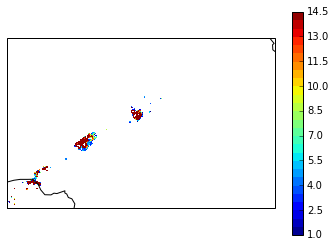

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, rainrs, levels=np.arange(1,15, 0.5), transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()

###### Get your corresponding MSG blob file!

In [10]:
path = "/users/global/cornkle/data/OBS/meteosat_WA30/cell_blob_files/2011/06/"  # 201106122130 good to show
filename = "201106122130.gra"
files = path + filename
rrShape = (580,1640)
rrMDI = np.uint16()
rr = np.fromfile(files,dtype=rrMDI.dtype) 

rr.shape = rrShape
print(rr.shape)

(580, 1640)


In [12]:
msg_latlon=np.load('/users/global/cornkle/data/OBS/meteosat_WA30/MSG_1640_580_lat_lon.npz')
mlon = msg_latlon['lon']
mlat = msg_latlon['lat']

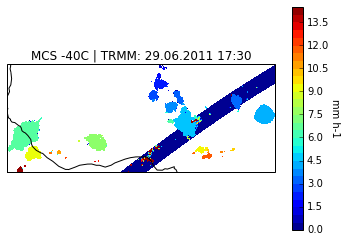

In [40]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, rainrs, levels=np.arange(0,15, 0.5), transform=ccrs.PlateCarree())
cbar=plt.colorbar()
cbar.set_label('mm h-1', rotation=270, labelpad=+11)
plt.contourf(mlon, mlat, rr, levels=np.arange(1,max(rr.flatten()),1), transform=ccrs.PlateCarree())
#plt.contour(lon, lat, rainrs, levels=np.arange(1,15, 0.5), transform=ccrs.PlateCarree())

plt.title('MCS -40C | TRMM: 29.06.2011 17:30')
#plt.contourf(mlon, mlat, maski, levels=np.arange(999,1001,1), transform=ccrs.PlateCarree())
#plt.contour(lon, lat, rtest+200, levels=np.arange(1000,1200,10), transform=ccrs.PlateCarree())
ax.coastlines()
plt.savefig('/users/global/cornkle/grpm/no_swath.png', dpi=300)

Thats blob 30!

<matplotlib.colorbar.Colorbar instance at 0x7f97f0c7e368>

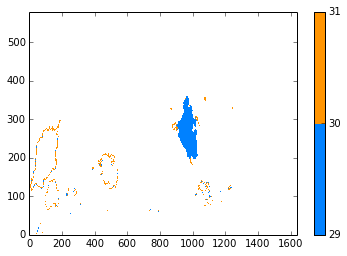

In [16]:
img=plt.contourf(rr, [29, 30, 31], interpolation='none')
plt.colorbar()

###### We also need the actual MSG temperatures, so here we go!

In [2]:
rfile='/users/global/cmt/msg/WAfrica/archive_WAfrica/ch9/2011/06/201106122130.gra' #works!

rShape = (580,1640)
rMDI = np.uint8(255)
r = np.fromfile(rfile,dtype=rMDI.dtype)
r.shape = rShape
r = r.astype(np.int32) - 173

NameError: name 'mlon' is not defined

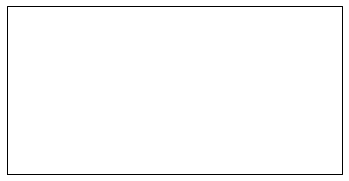

In [3]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(mlon, mlat, r, levels=np.arange(-80,0,2), transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()

In [10]:
msgp=msg.readMSGraw('/users/global/cmt/msg/WAfrica/archive_WAfrica/ch9/2011/06/201114122130.gra')
if not msgp:
           print 'yes'
print msgp        

yes
[False]


###### Instead of checking the area of every single blob in the blob file, we use the ready table! Makes things run faster and we just look at all blobs > 25.000km².  Here, we get 5 of them

In [19]:
df = pd.read_csv("/users/global/cornkle/data/OBS/meteosat/bigcell_area_table/rewrite/cell_40c_2130_JJAS.txt")
sel=df.loc[df['Date'] == '2011-06-12 21:30:00']
#print sel
#if '2013-09-01 20:00:00' in df['Date'].as_matrix(): print 'yes'
big = sel.loc[sel['Area'] >= 25000]
big.head()

,Unnamed: 0,Area,Lat,Lon,Mincol,Temp,Tresh,Date
43501,43501,26486,17.3,6.6,806,-50.95,-78,2011-06-12 21:30:00
43511,43511,25026,14.7,18.1,1211,-53.97,-77,2011-06-12 21:30:00
43519,43519,61346,12.6,22.3,1342,-65.45,-81,2011-06-12 21:30:00
43523,43523,94640,11.2,10.4,919,-60.19,-86,2011-06-12 21:30:00
43531,43531,148267,9.6,-14.0,6,-62.30,-91,2011-06-12 21:30:00


###### Now we use Eddy's magic to assign an MSG x,y index to all lat lons

In [5]:
mll = msg.ll_toMSG(mlon,mlat)

So where is the nb 30 in our blob file - here we get the indices 

In [8]:
isblob = np.where(rr == 30)
my=mll['y'][isblob]
mx=mll['x'][isblob]  

myy=mll['y']
mxx=mll['x']
mxy=(mxx+myy)*(mxx+myy+1)/2+myy  

<matplotlib.colorbar.Colorbar instance at 0x7f669dd50b48>

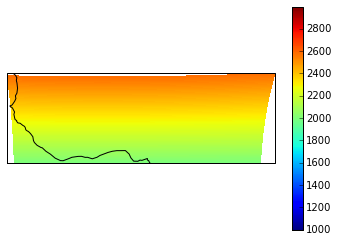

In [10]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(mlon, mlat, mll['y'], levels=np.arange(1000,3000,1), transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()

Do the same with TRMM lat lons of the swath!

In [23]:
ll_trmm = msg.ll_toMSG(lon,lat) #rainr                          

In [24]:
tx = ll_trmm['x']
ty = ll_trmm['y']

<matplotlib.colorbar.Colorbar instance at 0x7f97ee7afea8>

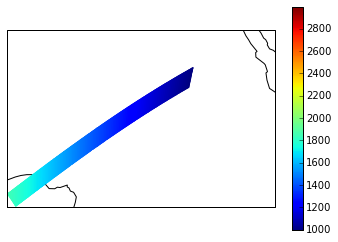

In [25]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contour(lon, lat, tx, levels=np.arange(1000,3000,1), transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()

Combine the x,y integers to a unique number (Cantor pairing function)

In [27]:
mpair=(mx+my)*(mx+my+1)/2+my
tpair=(tx+ty)*(tx+ty+1)/2+ty    

Create a mask of the blob - just for testing

In [28]:
maski=np.zeros_like(rr)
maski[isblob]=1000
np.where(maski>999)

(array([197, 198, 198, ..., 358, 358, 358]),
 array([1009, 1007, 1008, ...,  964,  965,  966]))

(array([197, 198, 198, ..., 294, 295, 295]),
 array([1009, 1008, 1011, ..., 1020, 1018, 1019]))

Find the intersecting uniq pairs for MSG blob (nb=30) and TRMM swath. Also..do the reverse to find the correct pixels in the raw MSG temperature

In [90]:
# Returns bolean array the same length as ar1 that is True where an element of ar1 is in ar2. Otherwise false

inter=np.in1d(tpair, mpair)    #returns false and true! whole grid
inter_rev=np.in1d(mpair, tpair.flat[inter])    #returns false and true! whole grid

# No intersection between Trmm and MSG? Continue!
if not inter.any(): 
    print 'No intersec'
print sum(inter)
print sum(inter_rev)
print len(isblob[0])
print r[isblob].flat[inter_rev].mean()

2043
2043
10361
-57.2971120901


In [121]:
rtest=np.copy(rainr)     # check the TRMM pixels identified       
rtest.flat[inter]=1000   #np.where(inter)

maskr=np.zeros_like(rr)
maskr[isblob]=1000
#np.where(maskr>999)

mxinter=np.in1d(mxy, mpair[inter_rev])
maskrr=np.zeros_like(rr)
maskrr.flat[mxinter]=1000
sum(mxinter)

2043

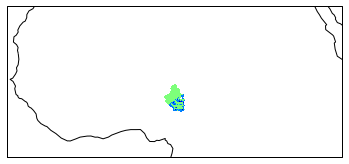

In [120]:
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.contourf(lon, lat, rainrs, levels=np.arange(0,15, 0.5), transform=ccrs.PlateCarree())

plt.contourf(mlon, mlat, maskr, levels=np.arange(900,1100,5), transform=ccrs.PlateCarree())  # green, MSG blob
plt.contourf(lon, lat, rtest+200, levels=np.arange(1000,1800,10), transform=ccrs.PlateCarree()) #identified TRMM pixel
# Identified MSG temperatures, problem: only nearest to TRMM, omits MSG pixels
plt.contourf(mlon, mlat, maskrr, levels=np.arange(900,1100,5), transform=ccrs.PlateCarree())  # green, MSG blob
ax.coastlines()